# Learning to Navigate with Gaussian Processes

In [4]:
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_point_clicker import clicker
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

import tueplots
from tueplots import bundles
plt.rcParams.update(bundles.neurips2022())

# Scientific computing
import numpy as np
import probnum
import itergp
import pykeops
pykeops.set_verbose(False)

## Path Planning

Imagine you've landed a robot on a remote planet and are now trying to explore that planet to find potential life forms. The spaceship which landed your robot is still orbiting the planet and taking measurements of the elevation to enable you to navigate on the planet.

<p style="text-align:center;">
<img src='learning_to_plan_illustration.jpg' width="800">
</p>

## Simulated Landscape
To give you an idea, on the left is a simulated landscape, versus the actual data you would obtain is on the right.

In [9]:
from landscapes import generate_landscape
from dataset import Dataset

# Simulated landscape
simulated_landscape_fn = generate_landscape(seed=42)

# Satellite measurements
num_train_data = 100000
simulated_train_data = Dataset(simulated_landscape_fn, num=num_train_data)

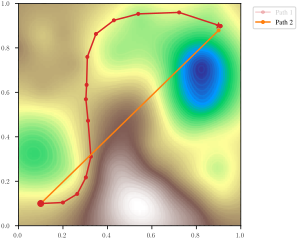

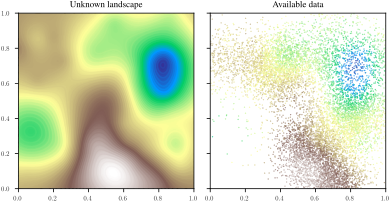

In [25]:
%matplotlib inline
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, axs = plt.subplots(ncols=2, sharex="row", sharey="row")

    # Plot simulated landscape
    x0s = np.linspace(0, 1.0, 100)
    x1s = np.linspace(0, 1.0, 100)
    X0, X1 = np.meshgrid(x0s, x1s)
    X_eval = np.vstack([X0.ravel(), X1.ravel()]).T
    F = simulated_landscape_fn(X_eval).reshape(X0.shape)
    axs[0].contour(X0, X1, F, levels=50, cmap="terrain")
    axs[0].imshow(
        F,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
    )

    # Simulated landscape data
    n_subset = np.minimum(10000, num_train_data) # Subset training data for plot
    axs[1].scatter(simulated_train_data.X[0:n_subset, 0], simulated_train_data.X[0:n_subset, 1], c=simulated_train_data.y[0:n_subset], cmap="terrain", s=0.1)

    # Plot settings
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0, 1.0)
    axs[0].set(title="Unknown landscape")
    axs[1].set(title="Available data")
    plt.show()

### Path Planning

Now to explore the remote planet we want to move with our robot to a certain location. However, we only have limited energy resources available and need to find a path that is efficient to drive along.

In [12]:
startpoint = np.asarray([0.1, 0.1])
endpoint = np.asarray([0.9, 0.9])

You can plan two different paths in the widget below and measure their energy cost. Try to gain an intuition which paths are energy costly and which are efficient. 

*Hint:* You can add points by clicking on the corresponding path in the legend and remove points by right-clicking near the point to be removed. The endpoint is added to the path automatically later.

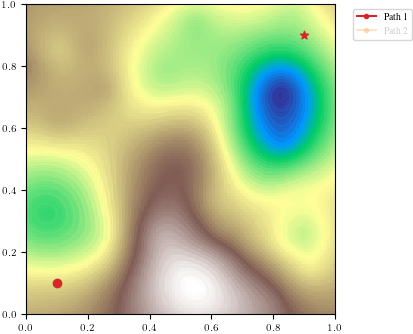

In [15]:
%matplotlib widget
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, ax = plt.subplots()

    # # Landscape data
    # n_subset = np.minimum(10000, num_train_data) # Subset training data for plot
    # ax.scatter(simulated_train_data.X[0:n_subset, 0], simulated_train_data.X[0:n_subset, 1], c=simulated_train_data.y[0:n_subset], cmap="terrain", s=0.1)

    # Simulated landscape
    ax.contour(X0, X1, F, levels=50, cmap="terrain")
    ax.imshow(
        F,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
    )

    # Plot start and endpoints
    ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
    ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Manual path planning
    path_list = ["Path 1", "Path 2"]
    klicker = clicker(ax, path_list, markers=[".", "."], colors=["C3", "C1"], linestyle= "-")
    klicker.set_positions({path: np.reshape(startpoint, (-1, 2)) for path in path_list})
    
    # Plot settings
    ax.set_aspect("equal")
    # ax.set_facecolor("black")
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.0)
    plt.show()


In [16]:
# Get paths from widget
path1 = np.unique(klicker.get_positions()["Path 1"], axis=0)
path2 = np.unique(klicker.get_positions()["Path 2"], axis=0)

print(path1)

[[0.1        0.1       ]
 [0.19991786 0.1044338 ]
 [0.26445166 0.14315408]
 [0.30317193 0.21736794]
 [0.30317193 0.56907711]
 [0.30639862 0.6336109 ]
 [0.30962531 0.7594518 ]
 [0.312852   0.47227642]
 [0.32575876 0.31094194]
 [0.34834559 0.86270587]
 [0.42901283 0.92401297]
 [0.53872028 0.95305318]
 [0.72264159 0.95950656]
 [0.90978959 0.89819945]]


Energy cost of path 1:  3.4153
Energy cost of path 2:  7.3533


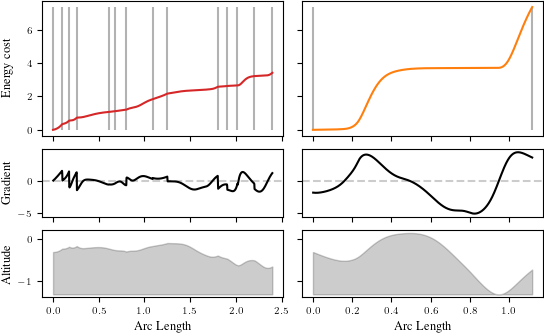

In [19]:
from cost_functions import movement_cost

# Measure energy cost of moving on simulated landscape
movement_cost1 = movement_cost(path1, landscape=simulated_landscape_fn)
movement_cost2 = movement_cost(path2, landscape=simulated_landscape_fn)

print(f"Energy cost of path 1: {movement_cost1['total_cost']: 4.4f}")
print(f"Energy cost of path 2: {movement_cost2['total_cost']: 4.4f}")

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, axs = plt.subplots(
        nrows=3, ncols=2, sharex="col", sharey="row", height_ratios=(1.0, 0.5, 0.5)
    )

    for idx, movement_cost in enumerate([movement_cost1, movement_cost2]):
        # Energy cost
        axs[0, idx].plot(
            movement_cost["arc_lengths"],
            movement_cost["cumulative_cost"],
            color=["C3", "C1"][idx],
        )

        # Curve points
        axs[0, idx].vlines(
            movement_cost["arc_lengths_to_points"],
            ymin=0.0,
            ymax=np.maximum(movement_cost1["total_cost"], movement_cost2["total_cost"]),
            color="black",
            alpha=0.3,
            zorder=-10,
        )

        # Gradient
        axs[1, idx].plot(
            movement_cost["arc_lengths"][1:],
            movement_cost["gradient"],
            color="black",
        )
        axs[1, idx].axhline(color="black", alpha=0.2, linestyle="--")

        # Altitude
        axs[2, idx].fill_between(
            movement_cost["arc_lengths"],
            movement_cost["elevation"],
            np.min(
                np.concatenate(
                    [movement_cost1["elevation"], movement_cost2["elevation"]]
                )
            ),
            color="black",
            alpha=0.2,
        )
        axs[2, idx].set(xlabel="Arc Length")

    axs[0, 0].set(ylabel="Energy cost")
    axs[1, 0].set(ylabel="Gradient")
    axs[2, 0].set(ylabel="Altitude")

    fig.align_ylabels()

    plt.show()

In [20]:
plt.close()

## Landscape data

Now of course in practice, we do not know the actual landscape and therefore cannot measure the energy cost of a planned path until we have actually driven to the target location. Therefore, we have *only one shot* at planning an efficient path.

In [21]:
# True landscape unknown to our robot
landscape_fn = generate_landscape(seed=17)

# Satellite measurements
num_train_data = 100000
train_data = Dataset(landscape_fn, num=num_train_data)
train_data.X.shape

(100000, 2)

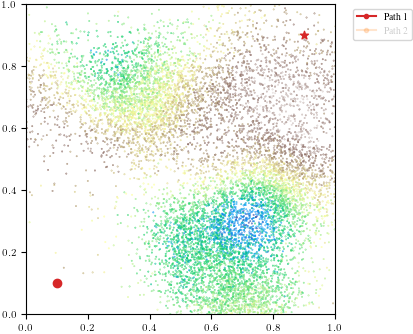

In [22]:
# Path planning using data only
%matplotlib widget
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, ax = plt.subplots()

    # Landscape data
    n_subset = np.minimum(10000, num_train_data) # Subset training data for plot
    ax.scatter(train_data.X[0:n_subset, 0], train_data.X[0:n_subset, 1], c=train_data.y[0:n_subset], cmap="terrain", s=0.1)

    # Plot start and endpoints
    ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
    ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Manual path planning
    path_list = ["Path 1", "Path 2"]
    klicker = clicker(ax, path_list, markers=[".", "."], colors=["C3", "C1"], linestyle= "-")
    klicker.set_positions({path: np.reshape(startpoint, (-1, 2)) for path in path_list})
    
    # Plot settings
    ax.set_aspect("equal")
    # ax.set_facecolor("black")
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.0)
    plt.show()


In [ ]:
# Get paths from widget
path1 = np.unique(klicker.get_positions()["Path 1"], axis=0)
path2 = np.unique(klicker.get_positions()["Path 2"], axis=0)

# Learning the Landscape

Path planning is quite difficult simply from the datapoints. Let's try to learn the surface of the remote planet from the data and then plan a path based on the inferred landscape. Since we want to use energy conservatively, we need a model with uncertainty, to avoid unknown hills or valleys. We'll use a Gaussian process for this purpose.

## Gaussian Processes

From previous missions, we have a rough idea of what geological structures on the remote planet look like and how the landscape varies. We can encode this knowledge in the prior by selecting a specific kernel. We also have a rough idea of what the noise in the measurement data is from the data our satellite collects.

In [27]:
from probnum import randvars, linops
from probnum.randprocs import mean_fns
from itergp.kernels import Matern
from itergp import GaussianProcess, methods

input_shape=(2,)

# GP prior
mean_fn = mean_fns.Zero(input_shape)
kernel = Matern(input_shape, lengthscale=0.2, nu=3.5)

gp = GaussianProcess(mean_fn, kernel)

# Likelihood
sigma_sq = 0.1
noise = randvars.Normal(
    mean=np.zeros_like(train_data.y),
    cov=linops.Scaling(sigma_sq, shape=(num_train_data, num_train_data)),
)

In [72]:
from probnum import backend

x0s = np.linspace(0, 1.0, 100)
x1s = np.linspace(0, 1.0, 100)
X0, X1 = np.meshgrid(x0s, x1s)
X_eval = np.vstack([X0.ravel(), X1.ravel()]).T

samples_2D = gp.sample(backend.random.rng_state(0), X_eval, sample_shape=(3, ))


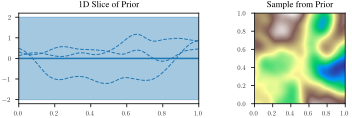

In [76]:
# Prior visualization
with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0, ncols=2)):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)

    # 1D slice with samples
    X_eval_slice = np.vstack([x0s, 0.5 * np.ones_like(x0s)]).T
    gp_mean = gp.mean(X_eval_slice)
    axs[0].plot(X_eval_slice, gp_mean, color="C0")
    axs[0].fill_between(x0s, y1=gp_mean + 2 * gp.std(X_eval_slice), y2=gp_mean - 2* gp.std(X_eval_slice), color="C0", alpha=0.4)

    axs[0].set(title="1D Slice of Prior")
    axs[0].plot(x0s, samples_2D.reshape(-1, *X0.shape)[0:3,:, 0].T, color="C0", linestyle="--", lw=1.0)


    # Sample of prior
    axs[1].imshow(
        samples_2D.reshape(-1, *X0.shape)[0, :, :],
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
    )
    axs[1].set(title="Sample from Prior")

    # Plot settings
    axs[1].set_aspect("equal")
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0, 1.0)
    
    plt.show()



## Scaling to Large Datasets

In [9]:
# Implement Gaussian process via Cholesky decomposition


In [10]:
# Fit GP on >100000 data points

# Need kernel matrix -> 149 GiB ~= 160 GB
Khat = kernel.matrix(train_data.X) + sigma_sq * np.eye(num_train_data)

MemoryError: Unable to allocate 149. GiB for an array with shape (100000, 100000, 2) and data type float64

### Matrix-free Kernel Matrices

Kernel operations without memory overflow, (with autodiff and on the GPU): [KeOps](https://www.kernel-operations.io/keops/index.html).

<p style="text-align:center;">
<img src='keops.png' width="800">
</p>

In [11]:
# Matrix-free representation of kernel matrix as "linear operator"
K = kernel.linop(train_data.X)

# Large-scale matrix-vector product still possible
(K @ np.ones(num_train_data)).shape

(100000,)

## Computation-Aware Inference

Accurate images on satellite around Mars, but communication with earth is slow and hardware is limited on satellite / robot. Need fast inference with little computation time. Can accept uncertainty, if path planning still is possible.

In [12]:
# Iterative gp posterior
gp_post = gp.condition_on_data(
    train_data.X, train_data.y, noise, approx_method=methods.Cholesky(maxrank=10)
)


In [ ]:
import cProfile

# Profile to understand which calls are expensive
# totime:  total time spent in the given function (excluding time in calls to sub-functions)
# cumtime: cumulative time spent in this and all subfunctions

cProfile.run(
    "gp.condition_on_data(train_data.X, train_data.y, noise, approx_method=methods.CG(maxiter=3))",
    sort="tottime",
)


In [126]:
# GP prediction on a million datapoints
xs = np.linspace(0, 1.0, 1000)
ys = np.linspace(0, 1.0, 1000)
X, Y = np.meshgrid(xs, ys)
X_pred = np.vstack([X.ravel(), Y.ravel()]).T
y_pred = gp_post.mean(X_pred)
uncertainty = gp_post.std(X_pred)

In [127]:
X_pred.shape

(1000000, 2)

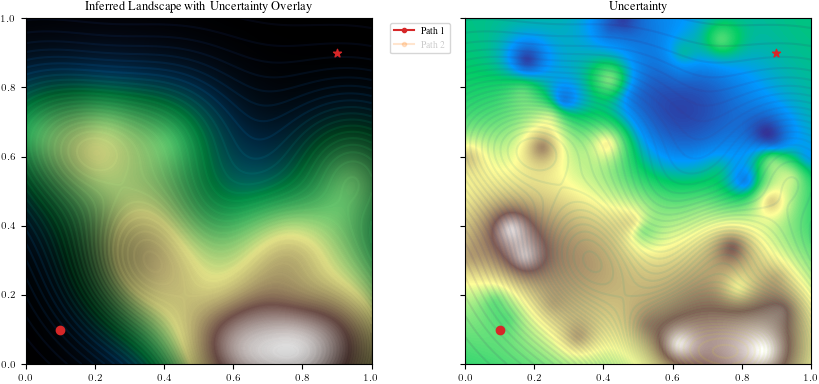

In [150]:
%matplotlib widget
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.5)):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)

    # Evaluate landscape function for plotting
    use_uncertainty_overlay = True

    if use_uncertainty_overlay:
        black_background = np.full((*X.shape, 3), 0, dtype=np.uint8)
        axs[0].imshow(black_background)
        uncertainty_overlay = 1.0 - uncertainty.reshape(X.shape)/np.max(uncertainty)

    axs[0].contour(X, Y, y_pred.reshape(X.shape), levels=50, cmap="terrain", alpha=0.1)
    axs[0].imshow(
        y_pred.reshape(X.shape),
        alpha=uncertainty_overlay if use_uncertainty_overlay else None,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
    )

    # Uncertainty
    axs[1].contour(X, Y, y_pred.reshape(X.shape), levels=50, alpha=0.1)
    axs[1].imshow(
        uncertainty.reshape(X.shape),
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
    )
    axs[1].imshow(
        landscape_fn(X_pred).reshape(X.shape),
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain"
    )


    # Plot start and endpoints
    for ax in axs:
        ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
        ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Manual path planning
    path_list = ["Path 1", "Path 2"]
    klicker = clicker(axs[0], path_list, markers=[".", "."], colors=["C3", "C1"], linestyle= "-")
    klicker.set_positions({path: np.reshape(startpoint, (-1, 2)) for path in path_list})

    # Plot settings
    axs[0].set_title("Inferred Landscape with Uncertainty Overlay" if use_uncertainty_overlay else "Inferred Landscape")
    axs[1].set_title("Uncertainty")
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[0].set_xlim(0, 1.0)
    axs[0].set_ylim(0, 1.0)
    plt.show()


In [146]:
# Create paths and add endpoint to each path
path1 = np.unique(klicker.get_positions()["Path 1"], axis=0)
path2 = np.unique(klicker.get_positions()["Path 2"], axis=0)

# Predict energy cost based on GP
print(
    f"Predicted energy cost of path 1: {movement_cost(path1, landscape=gp_post.mean): 4.4f}"
)
print(
    f"Predicted energy cost of path 2: {movement_cost(path2, landscape=gp_post.mean): 4.4f}"
)


Predicted energy cost of path 1:  5.2891
Predicted energy cost of path 2:  3.1635


In [147]:
# TODO: plot belief over elevation change

True energy cost of path 1:  1300137.2536
True energy cost of path 2:  10.9243


### Design Your Own Approximation Method

In [132]:
# TODO: imshow part of kernel matrix and plot sparse vector

In [122]:
from typing import Optional
from probnum.backend.random import RNGState

import probnum
from probnum import backend
from probnum.linalg.solvers import ProbabilisticLinearSolver, information_ops, policies

from itergp.methods import belief_updates, stopping_criteria


class MyPolicy(policies.LinearSolverPolicy):

    def __init__(self) -> None:
        super().__init__()

    def __call__(
        self,
        solver_state: "probnum.linalg.solvers.LinearSolverState",
        rng: Optional[RNGState],
    ) -> backend.Array:
        """Return an action for a given solver state.

        Parameters
        ----------
        solver_state
            Current state of the linear solver.
        rng
            Random number generator state.

        Returns
        -------
        action
            Next action to take. Must have shape=(n,).
        """
        rng = np.random.default_rng(rng)

        # Random Gaussian actions
        # return rng.standard_normal(size=(solver_state.problem.A.shape[1],))

        # CG on subset of data
        action = np.zeros(solver_state.problem.A.shape[1])
        # action[0:2000] = solver_state.residual[0:2000]

        # CG along diagonal strip
        # idcs = np.where(np.abs(train_data.X[:, 0] - train_data.X[:, 1]) < 0.1)[0]
        # action[idcs] = solver_state.residual[idcs]

        # Start with data with high altitude
        idcs = np.where(train_data.y > 0.5)[0]
        action[idcs[solver_state.step]] = 1.0

        # Only data with small gradients
        # TODO:

        # Data with highest uncertainty (over gradients), etc...

        return action



In [123]:
class MySolver(ProbabilisticLinearSolver):
    r"""
    Parameters
    ----------
    atol
        Absolute tolerance.
    rtol
        Relative tolerance.
    maxiter
        Maximum number of iterations.
    """

    def __init__(
        self,
        atol: float = 1e-6,
        rtol: float = 1e-6,
        maxiter: int = None,
    ):
        super().__init__(
            policy=MyPolicy(),
            information_op=information_ops.ProjectedResidualInformationOp(),
            belief_update=belief_updates.ProjectedResidualBeliefUpdate(),
            stopping_criterion=stopping_criteria.MaxIterationsStoppingCriterion(
                maxiter=maxiter,
            )
            | probnum.linalg.solvers.stopping_criteria.ResidualNormStoppingCriterion(
                atol=atol, rtol=rtol
            ),
        )

In [124]:
gp_post = gp.condition_on_data(
    train_data.X, train_data.y, noise, approx_method=MySolver(maxiter=100)
)


In [129]:
# TODO: plan path and get energy cost from GP
# TODO: plan path and get actual energy cost

# TODO: Use clicker to let people choose observation points (and their weighing through an array later on)?
# TODO: Plot gradient vector field to choose path?



In [ ]:
# TODO: ensure PLS doesnt save all residuals in between to scale to 100k datapoints more easily?

# Final Results

Let's see how good the path is you've chosen based on the learned landscape. Compare with your neighbors who got the path with the least energy cost!

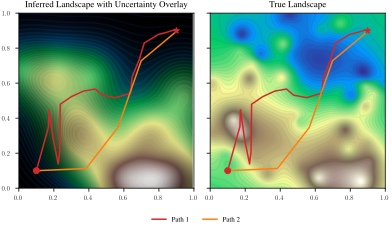

True energy cost of path 1:  1118245.7784
True energy cost of path 2:  10.9243


In [167]:
%matplotlib inline
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)

    # Inferred landscape with uncertainty overlay
    axs[0].contour(X, Y, y_pred.reshape(X.shape), levels=50, cmap="terrain", alpha=0.1)
    axs[0].imshow(black_background)
    axs[0].imshow(
        y_pred.reshape(X.shape),
        alpha=uncertainty_overlay if use_uncertainty_overlay else None,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
    )

    # Actual landscape
    y_true = landscape_fn(X_pred)
    axs[1].contour(X, Y, y_true.reshape(X.shape), levels=50, alpha=0.1)
    axs[1].imshow(
        y_true.reshape(X.shape),
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain"
    )

    # Plot start and endpoints
    for ax in axs[0:2]:
        ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
        ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Plot paths
    for ax in axs[0:2]:
        ax.plot(path1[:, 0], path1[:, 1], color="C3", label="Path 1")
        ax.plot(path2[:, 0], path2[:, 1], color="C1", label="Path 2")


    # Energy cost and elevation

    # Plot settings
    axs[0].set_title("Inferred Landscape with Uncertainty Overlay" if use_uncertainty_overlay else "Inferred Landscape")
    axs[1].set_title("True Landscape")
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[0].set_xlim(0, 1.0)
    axs[0].set_ylim(0, 1.0)

    # Legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles=handles,
        labels=labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.05),
        fancybox=False,
        shadow=False,
        ncol=2,
        frameon=False,
    )

    plt.show()


print(
    f"True energy cost of path 1: {movement_cost(path1, landscape=landscape_fn): 4.4f}"
)
print(
    f"True energy cost of path 2: {movement_cost(path2, landscape=landscape_fn): 4.4f}"
)

# Extensions?

- Predict gradient vector field with GP in closed form
- Actively collect / compute on data based on a driven segment
- ... student's ideas?

# References

Libraries:
- ProbNum 
- IterGP
- KeOps

Papers:
- Posterior and Computational Uncertainty
- BayesCG
- KeOps
- GPyTorch?